In [1]:
import mldatasets
import math
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, discriminant_analysis,\
                    ensemble, neural_network, inspection
import matplotlib.pyplot as plt
from pdpbox import pdp
from pycebox.ice import ice, ice_plot

In [2]:
birthorder_df = mldatasets.load("personality-birthorder")

https://openpsychometrics.org/_rawdata/FBPS-ValidationData.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter4/data/FBPS-ValidationData.zip
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter4/data/FBPS-ValidationData.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter4/data/FBPS-ValidationData
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter4/data/FBPS-ValidationData folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter4/data/FBPS-ValidationData/FBPS-ValidationData/FBPS-ValidationData.csv


In [3]:
birthorder_df.shape

(41841, 89)

In [4]:
birthorder_df = birthorder_df.drop(['dateload',\
                                    'submittime'], axis=1) 

In [5]:
birthorder_df.groupby(['gender']).size()

gender
0      238
1    16963
2    24130
3      510
dtype: int64

In [6]:
gender_df = pd.get_dummies(birthorder_df.gender).\
                rename({0:'gender_undefined', 1:'gender_male',\
                        2:'gender_female', 3:'gender_other'}, axis=1)

In [7]:
birthorder_df = pd.concat((\
                    birthorder_df.drop(['gender'], axis=1),\
                    gender_df), 1)

In [8]:
birthorder_df.groupby(['country']).\
        size().reset_index(name='counts').\
        sort_values(by='counts', ascending=False).head(5)

,country,counts
159,US,21860
53,GB,2600
25,CA,2448
7,AU,2140
117,NONE,823


In [9]:
birthorder_df = birthorder_df[(birthorder_df.\
                               country.isin(['US', 'GB', 'CA',\
                                             'AU', 'NZ', 'IE']))]

In [10]:
country_df = pd.get_dummies(birthorder_df.country).\
                rename({'AU':'country_AU', 'CA':'country_CA',\
                        'GB':'country_GB', 'IE':'country_IE',\
                        'NZ':'country_NZ', 'US':'country_US'}, axis=1)
birthorder_df = pd.concat((\
                    birthorder_df.drop(['country'], axis=1),\
                    country_df), 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1264a0b90>]],
      dtype=object)

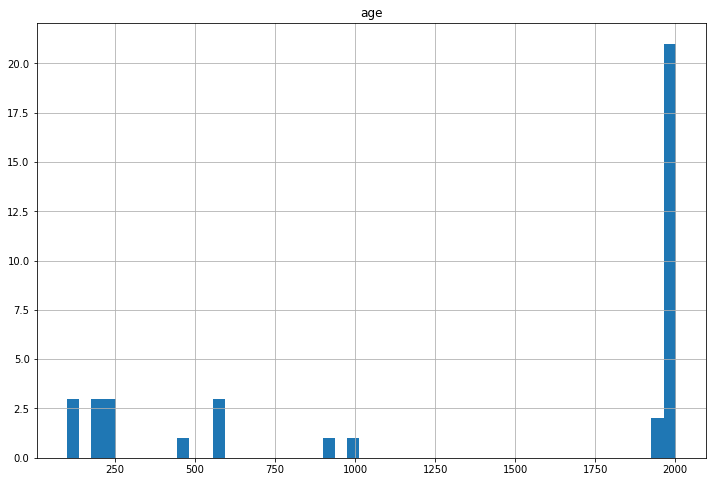

In [11]:
birthorder_df[(birthorder_df.age > 90)][['age']].hist(bins=50, figsize = (12,8))

In [12]:
birthorder_df = birthorder_df[birthorder_df.age <= 90]

In [13]:
birthorder_df = birthorder_df[(birthorder_df.birthn > 1) &\
                              (birthorder_df.birthn < 11) &\
                              (birthorder_df.birthpos <= birthorder_df.birthn) &\
                              (birthorder_df.birthpos > 0)]

In [14]:
#Initialize with default birth order (Unknown)
#Serves as a "catch-all" for when birthorder 
#can't be determined from `birthn` and `birthpos`
birthorder_df.loc[:, 'birthorder'] = 0
#Firstborn
birthorder_df.loc[(birthorder_df.birthpos == 1),\
                  'birthorder'] = 1
#Middle Child
birthorder_df.loc[(birthorder_df.birthpos > 1) &\
                  (birthorder_df.birthpos < birthorder_df.birthn),\
                  'birthorder'] = 2
#Lastborn
birthorder_df.loc[(birthorder_df.birthpos > 1) &\
                  (birthorder_df.birthpos == birthorder_df.birthn),\
                  'birthorder'] = 3

In [15]:
birthorder_df.groupby(['birthorder']).size()

birthorder
1    10886
2     6096
3     8831
dtype: int64

In [16]:
birthorder_df = birthorder_df.drop(['birthpos'], axis=1)
birthorder_df.shape

(25813, 95)

In [17]:
rand = 9
y = birthorder_df['birthorder']
X = birthorder_df.drop(['birthorder'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rand)

In [18]:
class_models = {  
        #Tree
        'decision_tree':{'model': tree.\
                         DecisionTreeClassifier(max_depth=6, random_state=rand,\
                                                class_weight='balanced')},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.\
                             GradientBoostingClassifier(n_estimators=200,\
                                                        max_depth=4, subsample=0.5,\
                                                        learning_rate=0.05)},
        'random_forest':{'model':ensemble.\
                         RandomForestClassifier(max_depth=11, n_estimators=300,\
                                                max_features='sqrt', random_state=rand)},
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.\
                    LogisticRegression(multi_class='ovr', solver='lbfgs',\
                                       class_weight='balanced', max_iter=500)},
        #Discriminant Analysis
        'lda':{'model':discriminant_analysis.\
               LinearDiscriminantAnalysis(n_components=2)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(), neural_network.\
                                     MLPClassifier(hidden_layer_sizes=(11,),\
                                                   early_stopping=True, random_state=rand,\
                                                   validation_fraction=0.25, max_iter=500))}
    }

In [19]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train) 
    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] =\
        metrics.accuracy_score(y_train, y_train_pred)
    class_models[model_name]['Accuracy_test'] =\
        metrics.accuracy_score(y_test, y_test_pred)
    class_models[model_name]['Recall_train'] =\
        metrics.recall_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Recall_test'] =\
        metrics.recall_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['Precision_train'] =\
        metrics.precision_score(y_train, y_train_pred, average='weighted')
    class_models[model_name]['Precision_test'] =\
        metrics.precision_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['F1_test'] =\
        metrics.f1_score(y_test, y_test_pred, average='weighted')
    class_models[model_name]['MCC_test'] =\
        metrics.matthews_corrcoef(y_test, y_test_pred)

In [20]:
class_metrics = pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                      'Recall_train', 'Recall_test',\
                                      'Precision_train', 'Precision_test',\
                                      'F1_test', 'MCC_test']]
class_metrics.sort_values(by='MCC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.43, high=0.63,\
                        subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=0.63, high=0.43,
                        subset=['Recall_train', 'Recall_test',\
                                'Precision_train', 'Precision_test',\
                                'F1_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,F1_test,MCC_test
decision_tree,0.496704,0.464139,0.496704,0.464139,0.541157,0.493572,0.44138,0.245647
logistic,0.495721,0.501233,0.495721,0.501233,0.488466,0.49255,0.490711,0.238174
gradient_boosting,0.623916,0.495481,0.623916,0.495481,0.635361,0.490412,0.482925,0.230107
mlp,0.527871,0.49149,0.527871,0.49149,0.525301,0.486532,0.483835,0.224034
random_forest,0.909564,0.48562,0.909564,0.48562,0.919258,0.481529,0.449015,0.201736
lda,0.500231,0.491255,0.500231,0.491255,0.498871,0.488547,0.47642,0.199604


In [21]:
print('NIR: %.4f' %\
      (y_train[y_train==1].shape[0]/y_train.shape[0]))

NIR: 0.4215


In [22]:
dt_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'dt_imp': class_models['decision_tree']['fitted'].\
                          feature_importances_})
gb_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'gb_imp': class_models['gradient_boosting']['fitted'].\
                          feature_importances_})
rf_imp_df = pd.DataFrame({\
                'name': X_train.columns,
                'rf_imp': class_models['random_forest']['fitted'].\
                         feature_importances_})

In [23]:
dt_rank_df = pd.DataFrame({'dt_rank':\
                           dt_imp_df['dt_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
gb_rank_df = pd.DataFrame({'gb_rank':\
                           gb_imp_df['gb_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})
rf_rank_df = pd.DataFrame({'rf_rank':\
                           rf_imp_df['rf_imp'].\
                           rank(method='first',\
                                ascending=False).astype(int)})

In [24]:
tree_ranks_df = pd.merge(\
                    pd.merge(\
                        pd.concat((dt_imp_df, dt_rank_df), axis=1),\
                        pd.concat((gb_imp_df, gb_rank_df), axis=1),\
                        'left'),\
                    pd.concat((rf_imp_df, rf_rank_df), axis=1),\
                    'left')
tree_ranks_df['avg_rank'] = (tree_ranks_df['dt_rank'] +\
                            tree_ranks_df['gb_rank'] + \
                            tree_ranks_df['rf_rank'])/3
tree_ranks_df.sort_values(by='avg_rank')

,name,dt_imp,dt_rank,gb_imp,gb_rank,rf_imp,rf_rank,avg_rank
28,birthn,0.851533,1,0.371212,1,0.198748,1,1.000000
82,testelapse,0.013708,3,0.036647,2,0.027573,2,2.333333
0,Q1,0.025340,2,0.023643,6,0.015931,6,4.666667
26,age,0.006679,7,0.028376,4,0.024830,3,4.666667
81,introelapse,0.005056,9,0.030471,3,0.022490,5,5.666667
...,...,...,...,...,...,...,...,...
90,country_GB,0.000000,91,0.001546,88,0.001947,90,89.666667
84,gender_undefined,0.000000,87,0.000952,90,0.000302,94,90.333333
87,gender_other,0.000000,89,0.000898,91,0.000632,92,90.666667
92,country_NZ,0.000000,93,0.001091,89,0.000737,91,91.000000


In [25]:
class_models['logistic']['fitted'].coef_.shape

(3, 94)

In [26]:
stdv = np.std(X_train, 0)
lr_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['logistic']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['logistic']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['logistic']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [27]:
class_priors = class_models['lda']['fitted'].priors_
class_priors

array([0.42147566, 0.23701862, 0.34150572])

In [28]:
lr_imp_df['coef_weighted_avg'] = (abs(lr_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lr_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lr_imp_df['last_coef_norm']) * class_priors[2])

In [29]:
lr_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.412945,1.3538,-0.0132044,0.499431
26,age,0.0552764,-0.0265002,-0.149019,0.0804694
0,Q1,0.110523,0.0224566,-0.00631052,0.0540604
12,Q13,0.0793163,-0.0382582,-0.000743793,0.0427518
15,Q16,0.0604051,-0.0542339,-0.000581668,0.0385124
19,Q20,-0.0609848,0.0508594,0.0015853,0.0382996
39,EST1,0.0498431,-0.0622704,0.00411372,0.0371717
3,Q4,0.044028,-0.0576418,-0.000594055,0.0324218
59,CSN1,0.0316447,-0.0699186,0.00127486,0.0303448
83,endelapse,-0.0502497,0.00710102,0.0190177,0.0293568


In [30]:
class_models['lda']['fitted'].coef_.shape

(3, 94)

In [31]:
lda_imp_df = pd.DataFrame({\
                'name': X_train.columns,\
                'first_coef_norm':\
                          class_models['lda']['fitted'].coef_[0] * stdv,\
                'middle_coef_norm':\
                          class_models['lda']['fitted'].coef_[1] * stdv,\
                'last_coef_norm':\
                          class_models['lda']['fitted'].coef_[2] * stdv}).\
            reset_index(drop=True)

In [32]:
lda_imp_df['coef_weighted_avg'] = (abs(lda_imp_df['first_coef_norm']) * class_priors[0]) +\
                                 (abs(lda_imp_df['middle_coef_norm']) * class_priors[1]) +\
                                 (abs(lda_imp_df['last_coef_norm']) * class_priors[2])

In [33]:
lda_imp_df.\
    sort_values(by='coef_weighted_avg', ascending=False).style.\
    background_gradient(cmap='viridis', low=-0.1, high=0.1,\
                        subset=['first_coef_norm',\
                                'middle_coef_norm', 'last_coef_norm'])

,name,first_coef_norm,middle_coef_norm,last_coef_norm,coef_weighted_avg
28,birthn,-0.315215,1.00305,-0.307128,0.475483
0,Q1,0.0899109,-0.0122606,-0.102456,0.0757905
12,Q13,0.0564803,-0.0337293,-0.0462968,0.0476102
51,AGR3,-0.0392475,-0.00558213,0.0523123,0.0357299
15,Q16,0.0395618,-0.0363935,-0.0235674,0.0333487
6,Q7,-0.00407858,0.0644172,-0.0396745,0.0305362
24,Q25,-0.0350918,0.0343628,0.01946,0.0295807
16,Q17,0.034915,-0.00978912,-0.036297,0.0294317
77,OPN9,-0.0326552,0.0447374,0.00925253,0.0275268
19,Q20,-0.0313594,0.0386032,0.0119107,0.0264345


In [34]:
class_models['mlp']['fitted'][1].coefs_[0].shape

(94, 11)

In [35]:
class_models['mlp']['fitted'][1].coefs_[1].shape

(11, 3)

In [36]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['fitted']
    permutation_imp = inspection.permutation_importance(\
                        fitted_model, X_test, y_test, n_jobs=-1,\
                        scoring='accuracy', n_repeats=8,\
                        random_state=rand)
    class_models[model_name]['importances_mean'] =\
                        permutation_imp.importances_mean

In [37]:
perm_imp_df = pd.DataFrame({
                'name': X_train.columns,\
                'dt_imp': class_models['decision_tree']['importances_mean'],\
                'gb_imp': class_models['gradient_boosting']['importances_mean'],\
                'rf_imp': class_models['random_forest']['importances_mean'],\
                'log_imp': class_models['logistic']['importances_mean'],\
                'lda_imp': class_models['lda']['importances_mean'],\
                'mlp_imp': class_models['mlp']['importances_mean']}).\
            reset_index(drop=True)

In [38]:
perm_imp_df['avg_imp'] = (perm_imp_df['dt_imp'] + perm_imp_df['gb_imp'] +\
                         perm_imp_df['rf_imp'] + perm_imp_df['log_imp'] +\
                         perm_imp_df['lda_imp'] + perm_imp_df['mlp_imp'])/6

In [39]:
perm_imp_sorted_df = perm_imp_df.round(5).\
    sort_values(by='avg_imp', ascending=False)
perm_imp_sorted_df.style.\
    background_gradient(cmap='viridis_r', low=0, high=0.2,\
                        subset=['dt_imp', 'gb_imp', 'rf_imp',\
                                'log_imp', 'lda_imp', 'mlp_imp'])

,name,dt_imp,gb_imp,rf_imp,log_imp,lda_imp,mlp_imp,avg_imp
28,birthn,0.1385,0.1087,0.07604,0.11818,0.08199,0.11172,0.10585
0,Q1,0.00832,0.00197,0.00428,0.00509,0.01103,0.0093,0.00667
26,age,0.00107,0.00396,0.00496,0.00713,-0.00122,0.00183,0.00296
12,Q13,0.00098,0.00097,-6e-05,0.00428,0.00235,0.00499,0.00225
16,Q17,0.00119,-0.0004,0.00255,0.00122,0.00179,0.00273,0.00151
51,AGR3,0.00032,0.00092,-0.00156,0.00109,0.00339,0.0039,0.00135
49,AGR1,0.00084,0.00211,0.00163,0.00189,-0.00062,0.00041,0.00104
4,Q5,-0.00079,0.00207,-0.00025,0.0011,0.00123,0.00267,0.00101
3,Q4,0,-0.0006,0.00163,0.00178,0.0006,0.00214,0.00092
31,EXT3,0,0.00095,0.00022,0.00091,-0.00139,0.00477,0.00091


In [40]:
pd.DataFrame.\
    from_dict(class_models, 'index')[['Accuracy_test']] -\
    perm_imp_sorted_df.iloc[0,1:7].to_numpy().reshape((6,1))

,Accuracy_test
decision_tree,0.325639
gradient_boosting,0.386781
random_forest,0.40958
logistic,0.383053
lda,0.409265
mlp,0.37977


In [41]:
feature_names = ['birthn', 'Q1', 'Q13', 'age']
feature_labels = ['# of Births', 'Question #1',\
                  'Question #13', 'Age']

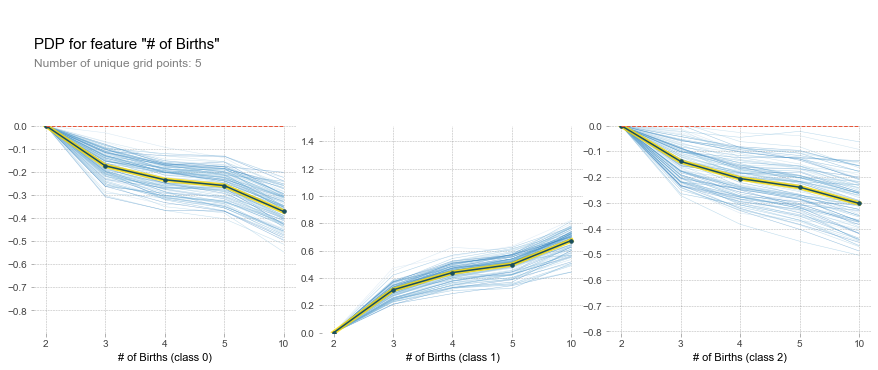

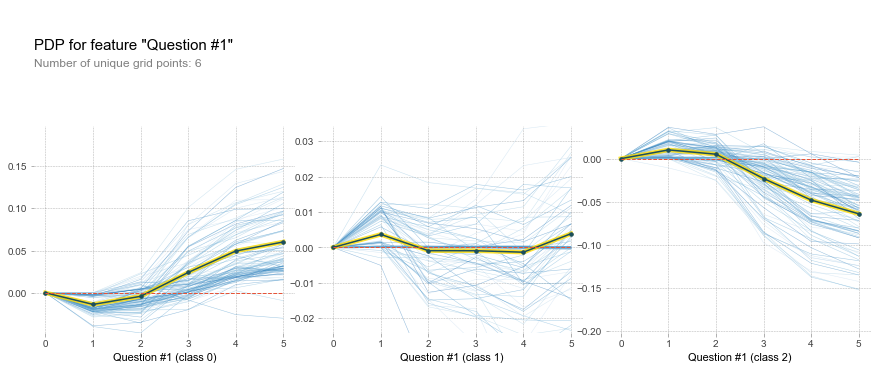

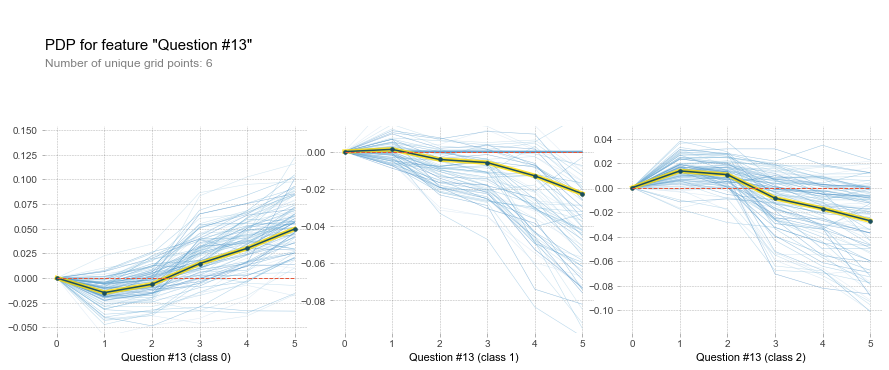

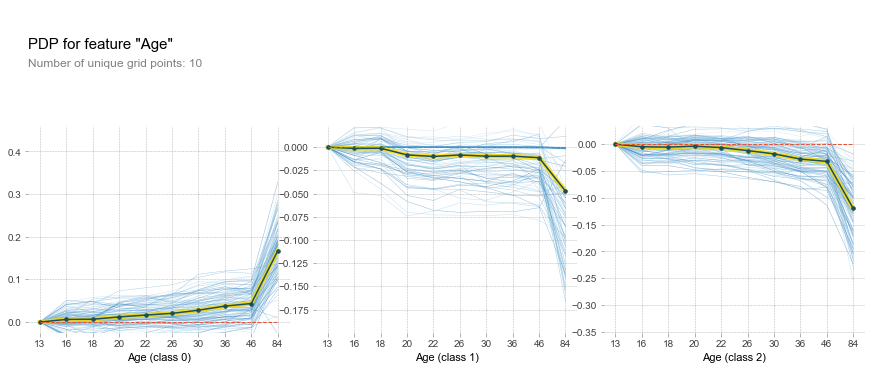

In [42]:
for i in range(len(feature_names)):
    pdp_feat_df = pdp.pdp_isolate(\
        model=class_models['gradient_boosting']['fitted'],\
        dataset=pd.concat((X_test, y_test), axis=1),\
        model_features=X_test.columns,\
        feature=feature_names[i]
    )
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True,\
        x_quantile=True, ncols=3, plot_lines=True,\
        frac_to_plot=100, figsize=(15,6),\
        feature_name=feature_labels[i]
    )

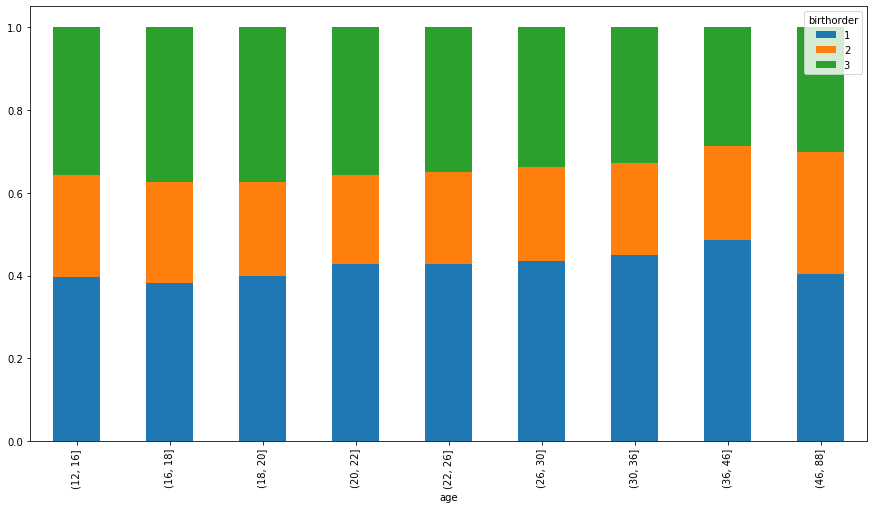

In [43]:
birthorder_abbrev_df = birthorder_df[['age', 'birthorder']]
birthorder_abbrev_df.set_index(pd.cut(\
                                  birthorder_abbrev_df['age'],\
                                  [12, 16, 18, 20, 22, 26, 30,\
                                   36, 46, 88]), inplace=True)
agegroup_birthorder_counts_s = birthorder_abbrev_df.\
                            groupby([birthorder_abbrev_df.index,\
                                     'birthorder']).size()
agegroup_counts_s = birthorder_abbrev_df.groupby(\
                                            birthorder_abbrev_df.index)\
                                            ['birthorder'].count()
agegroup_pct_birthorder_s = agegroup_birthorder_counts_s.div(\
                                                    agegroup_counts_s,\
                                                     axis=0,level=0)
agegroup_pct_birthorder_s.unstack().plot.bar(stacked=True,\
                                         figsize=(15,8))

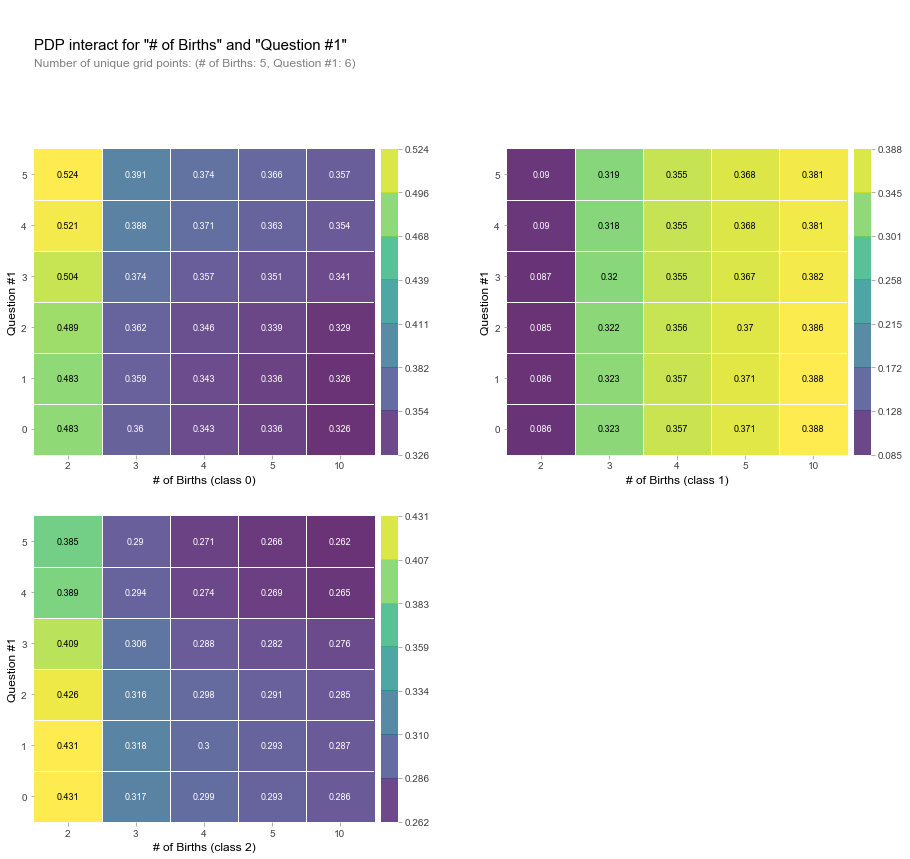

In [44]:
pdp_birthn_Q1_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['birthn','Q1'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_birthn_Q1_df,\
    plot_type='grid', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['# of Births','Question #1']
)

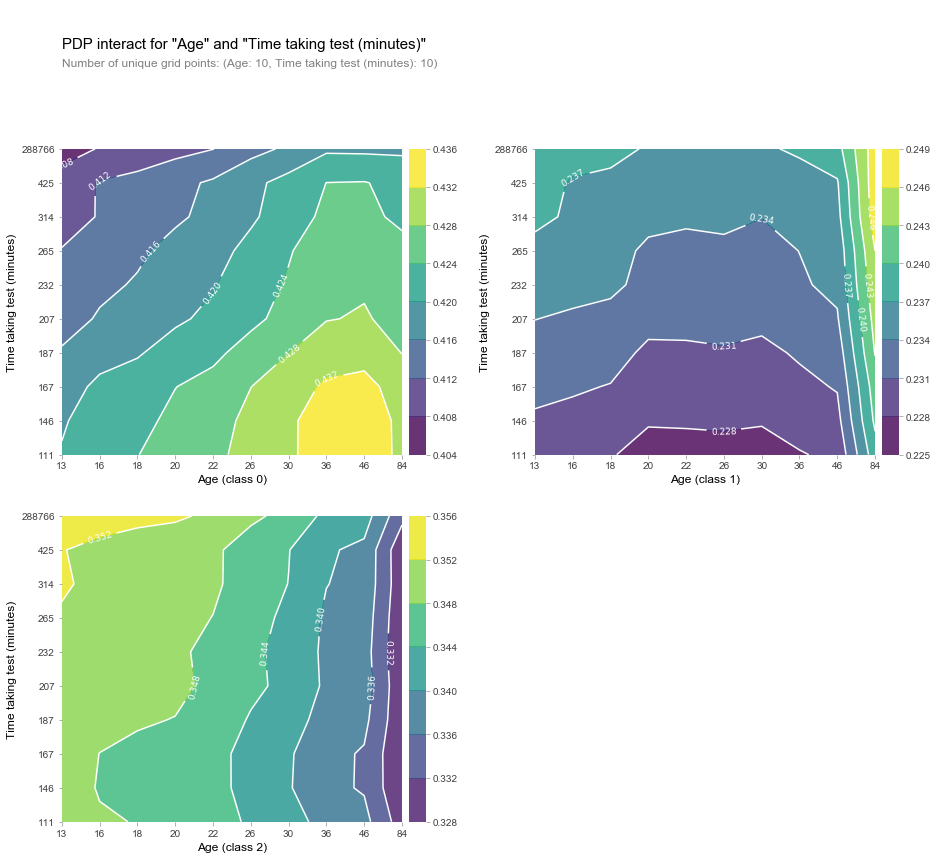

In [45]:
pdp_age_testelapse_df = pdp.pdp_interact(
    model=class_models['random_forest']['fitted'],\
    dataset=pd.concat((X_test, y_test), axis=1),\
    model_features=X_test.columns, features=['age','testelapse'],\
    n_jobs=-1
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=pdp_age_testelapse_df,\
    plot_type='contour', x_quantile=True,\
    ncols=2, figsize=(15,15),\
    feature_names=['Age','Time taking test (minutes)']
)

In [46]:
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(\
                    X_test.shape[0],\
                    math.ceil(X_test.shape[0]*sample_size),\
                    replace=False)
X_test_samp = X_test.iloc[sample_idx,:]

In [47]:
def predict_prob_first_born(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,0]
def predict_prob_middle_child(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,1]
def predict_prob_last_born(test_df):
    return class_models['random_forest']['fitted'].\
                                predict_proba(test_df)[:,2]

In [48]:
def plot_birthn_data_vs_ice(prob_function, ylabel):
    likert_scale = {0:'N/A', 1:'Disagree', 2:'Somewhat Disagree',\
                    3:'Neutral', 4:'Somewhat Agree', 5:'Agree'}
    ice_birthn_df = ice(X_test_samp, 'birthn',\
             prob_function, num_grid_points=None)
    fig, axs = plt.subplots(2, 1, sharex=False, sharey=True,\
                            figsize=(15,20))
    fig.subplots_adjust(hspace=0.15, wspace=0)
    scatter = axs[0].scatter(X_test_samp.birthn,\
                             prob_function(X_test_samp),\
                             c=X_test_samp.Q1, alpha=0.15)
    legend = axs[0].legend(*scatter.legend_elements(), loc='best')
    for s in likert_scale.keys(): 
        legend.get_texts()[s].set_text(likert_scale[s])
    axs[0].set_xlabel('# of Births', fontsize=12)
    axs[0].set_ylabel(ylabel, fontsize=12)
    axs[0].set_title('Data', fontsize=16)
    ice_plot(ice_birthn_df, color_by='Q1', alpha=0.15, ax=axs[1])
    axs[1].set_xlabel('# of Births', fontsize=12)
    axs[1].set_ylabel(ylabel, fontsize=12)
    axs[1].set_title('ICE Curves', fontsize=16)
    plt.show()

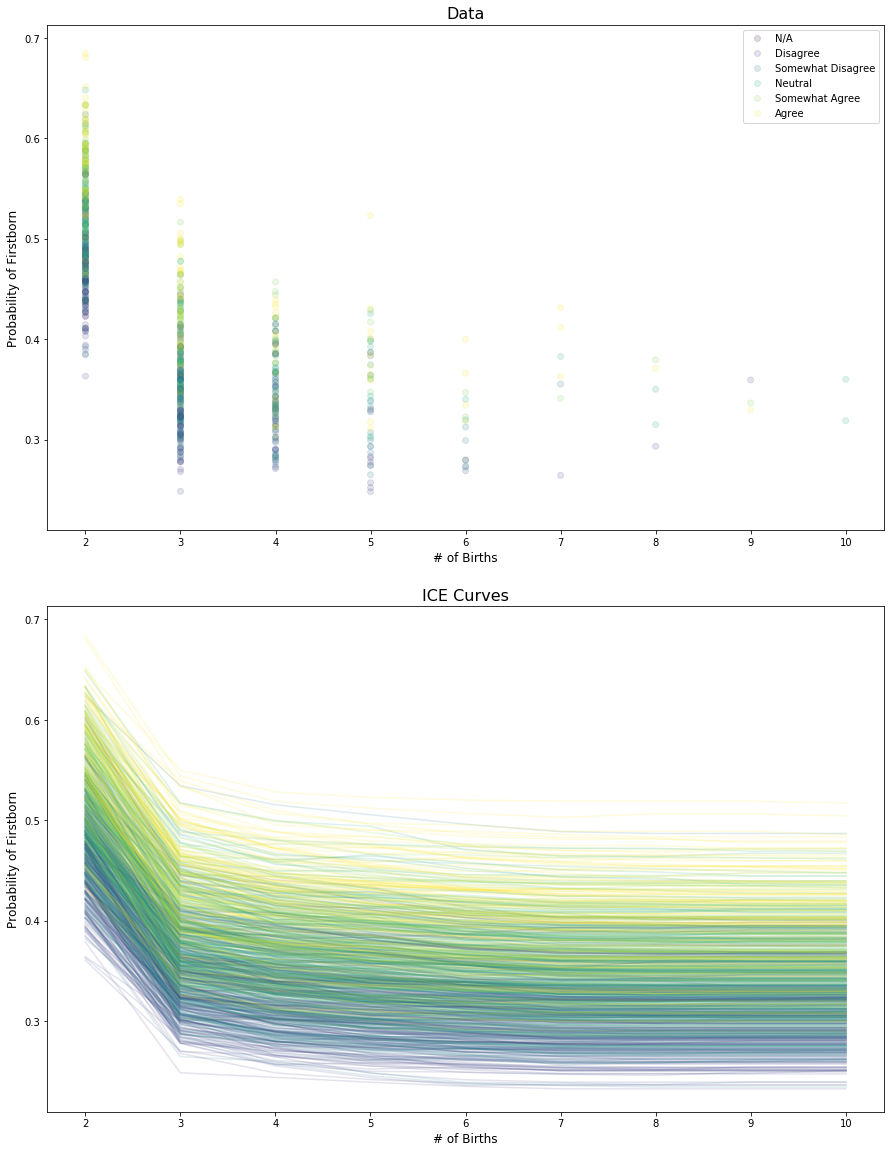

In [49]:
plot_birthn_data_vs_ice(predict_prob_first_born,\
                        'Probability of Firstborn')

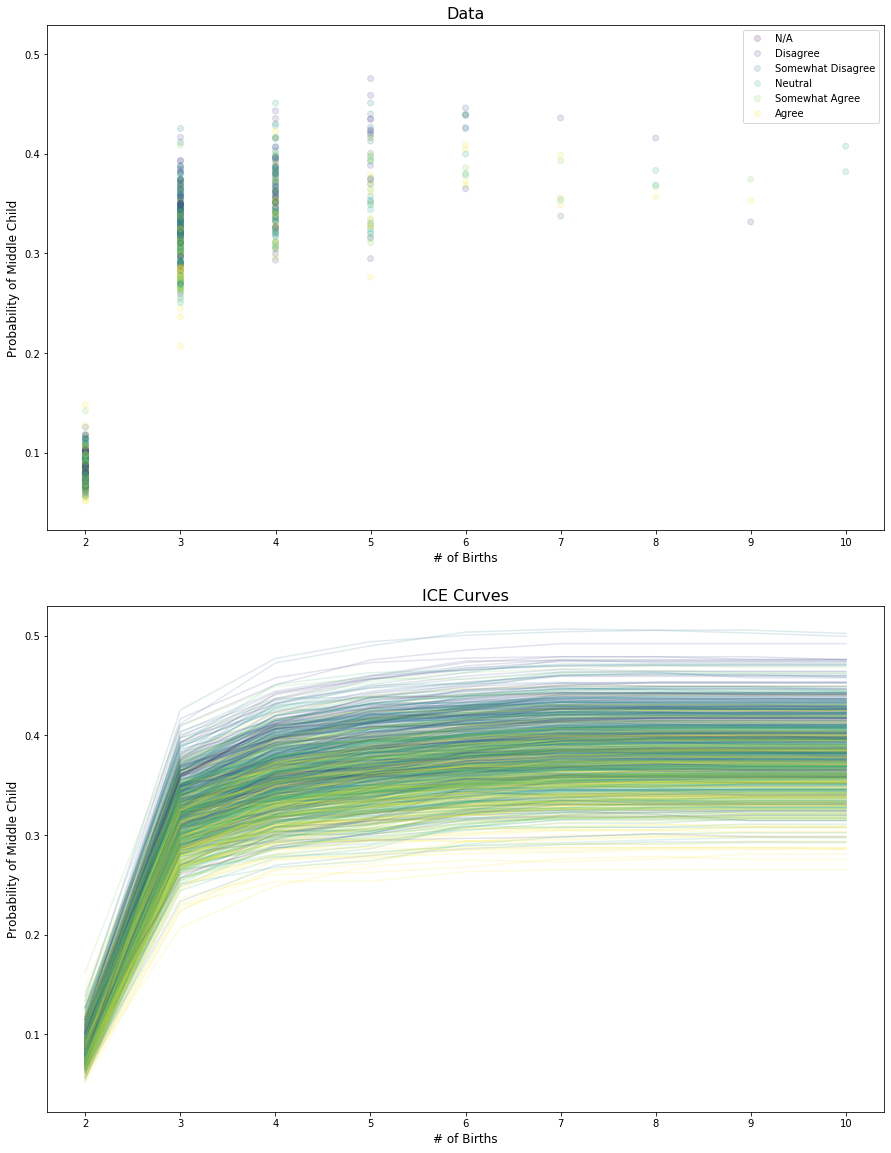

In [50]:
plot_birthn_data_vs_ice(predict_prob_middle_child,\
                        'Probability of Middle Child')

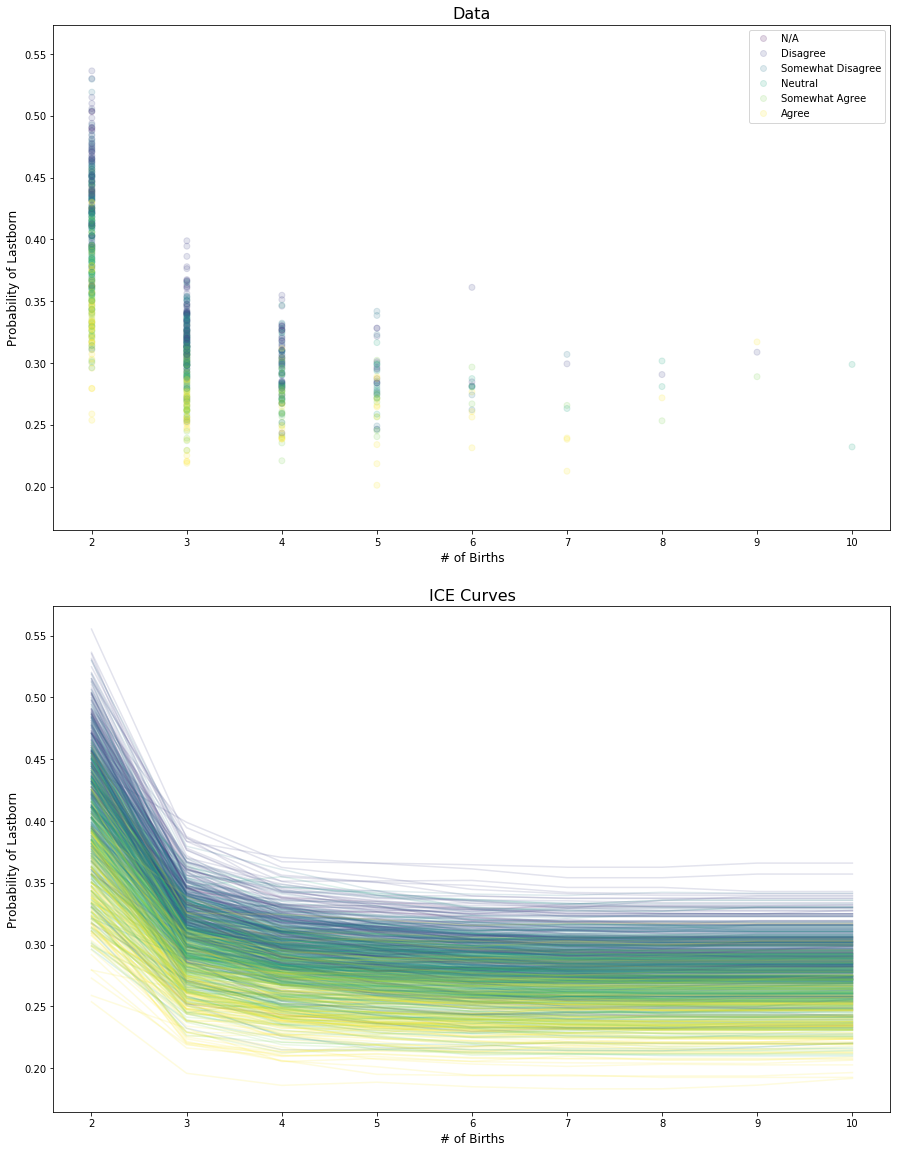

In [51]:
plot_birthn_data_vs_ice(predict_prob_last_born,\
                        'Probability of Lastborn')